# Imports

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Importing necessary modules for model evaluation and preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Importing GridSearchCV for hyperparameter tuning and mean_squared_error for model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# package that will help us to save tough models, this will allow us to run all notebook quickly 
import pickle as pk
from math import sqrt
import json
from sklearn.metrics import mean_squared_error

In [2]:
#pip install wordcloud

# Read CSVs

Datasets are available on the link in readME. Change the paths as needed.

In [3]:
path_movies ='../Datasets/movies.csv'
path_ratings = '../Datasets/ratings.csv' 
path_tags = '../Datasets/tags.csv' 

movies = pd.read_csv(path_movies)
ratings = pd.read_csv(path_ratings)
tags = pd.read_csv(path_tags)

# Movies Dataset

## Data Understanding

Basic stats of Movies Dataset. No null falues were found, so no missing data handling was made.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [6]:
movies.shape

(62423, 3)

In [7]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [9]:
movies.nunique()

movieId    62423
title      62325
genres      1639
dtype: int64

In [10]:
movies.duplicated().sum()

0

In [11]:
movies['title'].value_counts()

title
The Void (2016)                                2
Seven Years Bad Luck (1921)                    2
Clear History (2013)                           2
Enron: The Smartest Guys in the Room (2005)    2
Deranged (2012)                                2
                                              ..
$ellebrity (Sellebrity) (2012)                 1
Macabre (Macabro) (1980)                       1
Punk's Dead: SLC Punk! 2 (2014)                1
Chinese Hercules (1973)                        1
Women of Devil's Island (1962)                 1
Name: count, Length: 62325, dtype: int64

In [12]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [13]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

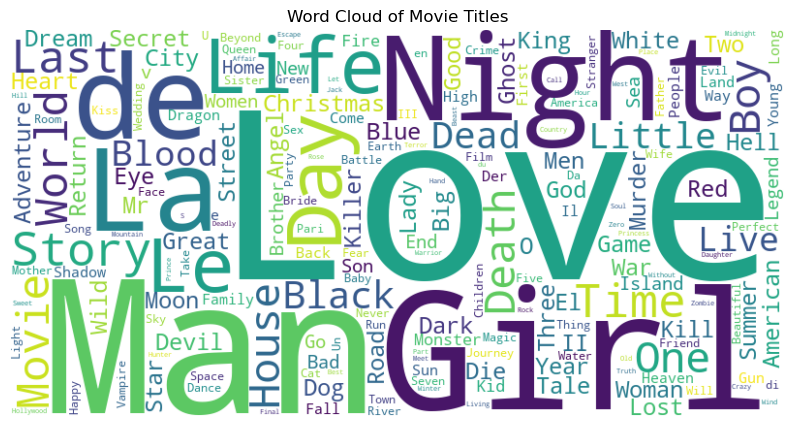

In [14]:
text = ' '.join(movies['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

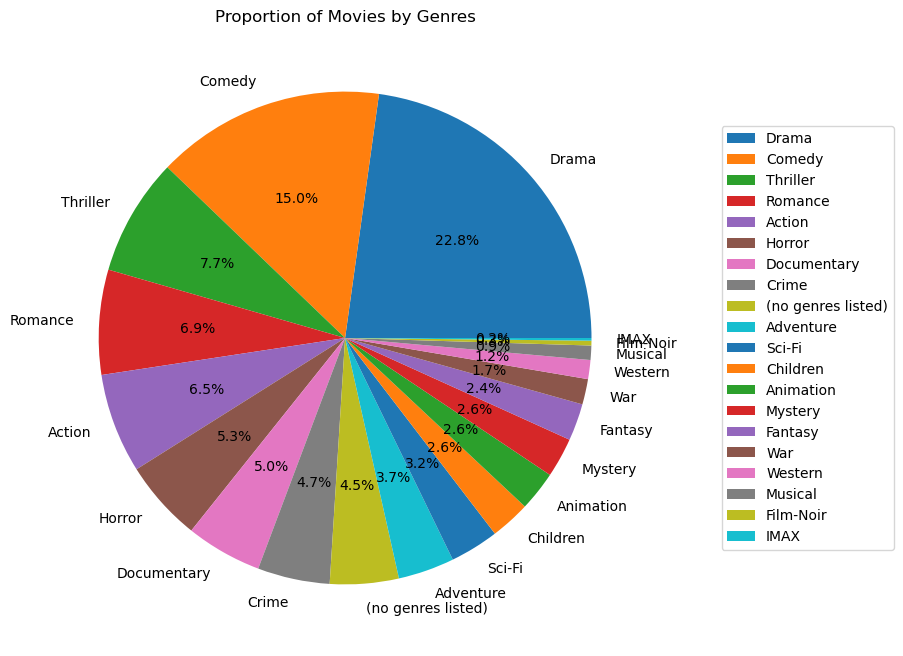

In [15]:
genres_count = movies['genres'].str.split('|', expand=True).stack().value_counts()

plt.figure(figsize=(10, 8))
genres_count.plot(kind='pie', autopct='%1.1f%%')
plt.legend(genres_count.index, loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
plt.title('Proportion of Movies by Genres')
plt.ylabel('')
plt.show()

# Data Preparation

## Genre splitting

In this process we will slice the genre column and do dummy encoding in it. This will enable us to work with the genres as if those are numerical values. 

In the code below 3 actions were done:
- Slicing of genres;
- Creation of genre_count column;
- Moving genre_count to the front of the new section.

In [16]:
# Separating genres to count them.
movie_genres = movies['genres'].str.get_dummies('|')
movie_genres.drop(columns=["(no genres listed)"], inplace=True)

# Creating the genre_count column, that calculate how many genres the movie has and gives a numerical value.
movie_genres['genre_count'] = movie_genres.iloc[:, 0:19].astype(bool).sum(axis=1)

# Moving the column to the front.
genre_count_column = movie_genres.pop('genre_count')
movie_genres.insert(0, 'genre_count', genre_count_column)
movie_genres.head()

,genre_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Below we just are going to merge these new columns to the main dataset:

In [17]:
# merge with original dataset.
movies_encoded = pd.concat([movies, movie_genres], axis=1)
movies_encoded.head()

,movieId,title,genres,genre_count,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Year Column addition

Another numerical value we can insert in this dataset is the year, because all movie names contain their year in parenthesis. In this code below we:

- Extracted year values;
- Filled NA values with 0 (in case some movies don't have the Year value in the correct format/ don't have the year value);
- Moved the column to the third position.

In [18]:
# Extraction of the year, and na filling
movies_encoded['year'] = movies_encoded['title'].str.extract(r'\((\d{4})\)')
movies_encoded['year'] = movies_encoded['year'].fillna(0).astype('int64')

# moving column around to the front
year_column = movies_encoded.pop('year')
movies_encoded.insert(2, 'year', year_column)

movies_encoded.head()

,movieId,title,year,genres,genre_count,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,Adventure|Animation|Children|Comedy|Fantasy,5,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,Adventure|Children|Fantasy,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,Comedy|Romance,2,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,Comedy|Drama|Romance,3,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,Comedy,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Data Understanding about genres 

### Movie with the highest number of genres

In [19]:
print("The movie with the most number of genres contains:", movies_encoded.genre_count.max(), "genres")
print("The movie moth most genres is:")
movies_max = movies_encoded[movies_encoded['genre_count'] == 10]
movies_max

The movie with the most number of genres contains: 10 genres
The movie moth most genres is:


,movieId,title,year,genres,genre_count,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
15389,81132,Rubber (2010),2010,Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,10,1,1,0,0,1,...,1,1,0,0,1,0,0,1,0,1


In [20]:
average_genre_count = round(movies_encoded['genre_count'].mean(), 2)
average_year = int(movies_encoded['year'].mean())
year_counts = movies_encoded['year'].value_counts().reset_index().head(10)

print("The average number of genres for each movie is: {:.2f}\nThe average year is: {}\nAnd these are the top 10 years for movies in our system:".format(average_genre_count, average_year))
year_counts

The average number of genres for each movie is: 1.72
The average year is: 1978
And these are the top 10 years for movies in our system:


,year,count
0,2015,2513
1,2016,2488
2,2014,2406
3,2017,2374
4,2013,2173
5,2018,2034
6,2012,1978
7,2011,1838
8,2009,1724
9,2010,1691


# EDA

## Genre

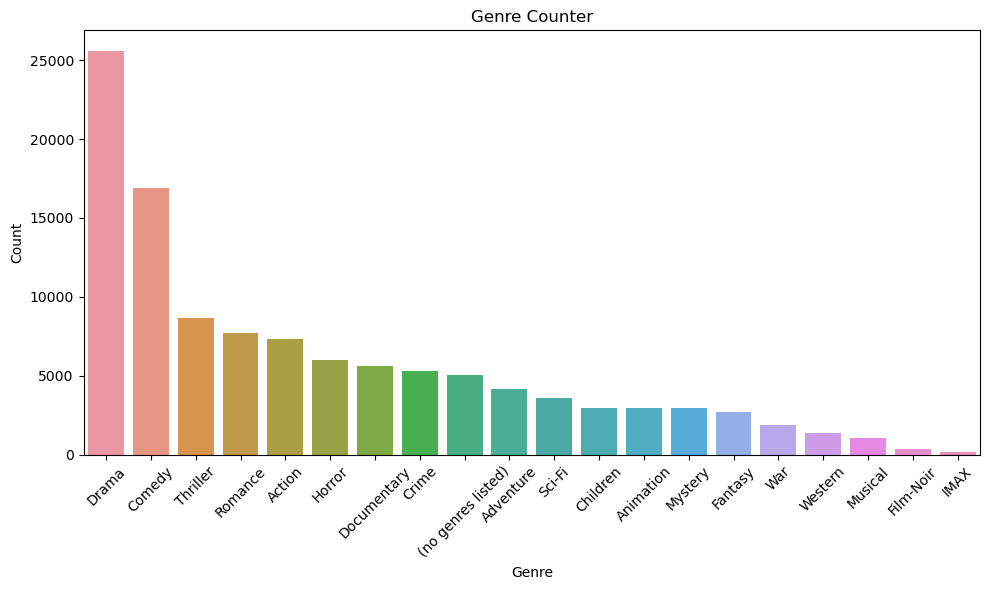

In [21]:
genres_count = movies_encoded['genres'].str.split('|', expand=True).stack().value_counts().reset_index()
genres_count.columns = ['genres', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='genres', y='count', data=genres_count)
plt.title('Genre Counter')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Year

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


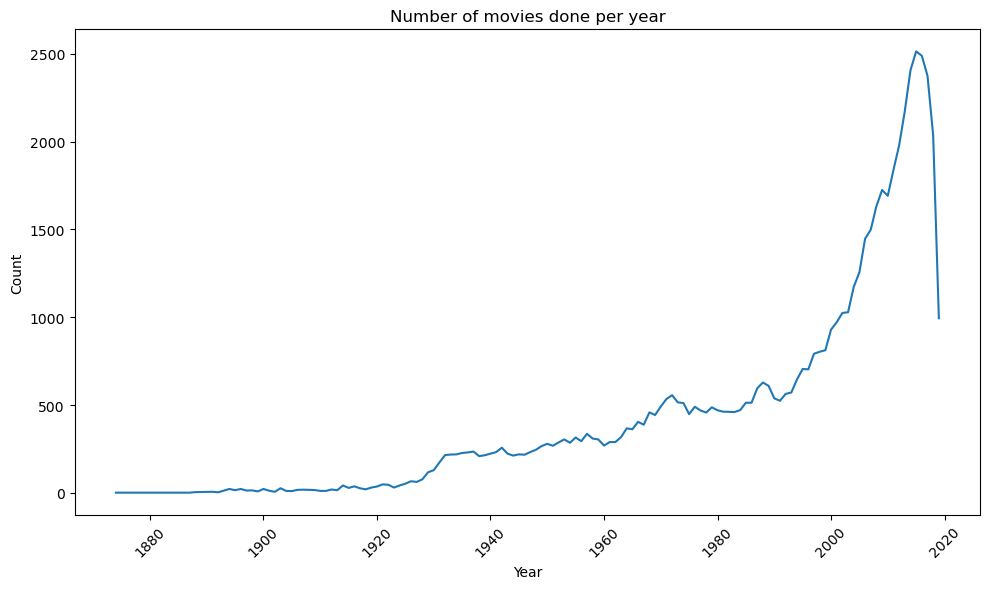

In [22]:
year_counts = movies_encoded['year'].replace(0, np.NaN)
year_counts = year_counts.dropna()
year_counts = year_counts.value_counts().reset_index()
year_counts

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='count', data=year_counts)
plt.title('Number of movies done per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

# Ratings dataset

## Data Understanding

In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [24]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [25]:
ratings.shape

(25000095, 4)

In [26]:
ratings.duplicated().sum()

0

In [27]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [28]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [29]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

array([[<Axes: title={'center': 'userId'}>,
        <Axes: title={'center': 'movieId'}>],
       [<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'timestamp'}>]], dtype=object)

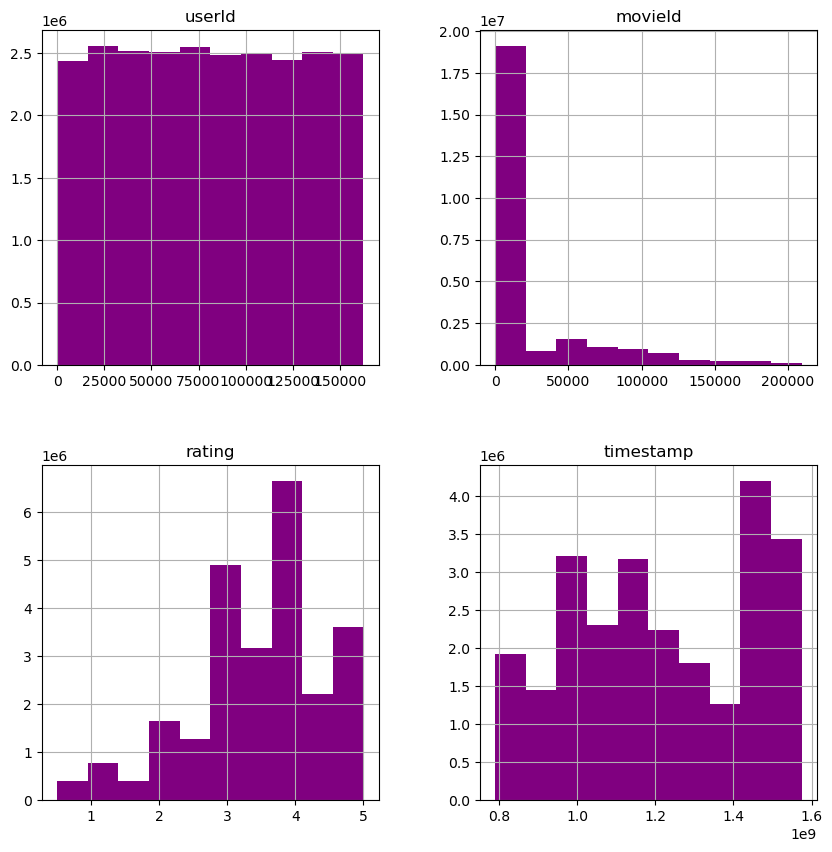

In [30]:
ratings.hist(figsize = (10,10), color="#800080")

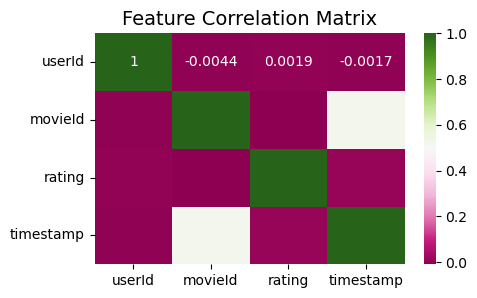

In [31]:
plt.figure(figsize=(5,3))
sns.heatmap(ratings.corr(), annot=True, cmap='PiYG')
plt.title("Feature Correlation Matrix",fontsize=14)
plt.show()

# Data preparation for Ratings

Since there are no missing values or duplicates, we can go on excluding the 'timestamp' column (it is not necessary for what we need).

In [32]:
ratings.drop(columns="timestamp",inplace = True)

# Merging datasets

To move forward we will use one dataset only, so we need to merge Movies_Encoded and Ratings. We will name this Merged, as in a merged dataframe.

In [33]:
# Merging movies_encoded and ratings dataframes 
merged = ratings.merge(movies_encoded,on="movieId")
merged.head()

,userId,movieId,rating,title,year,genres,genre_count,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [46]:
# Dropping genres because we will not need it further
merged.drop(columns="genres",inplace = True)

In [47]:
merged.shape

(25000095, 25)

In [48]:
merged.isnull().sum()

userId         0
movieId        0
rating         0
title          0
year           0
genre_count    0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
IMAX           0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [37]:
merged.isna().sum()

userId         0
movieId        0
rating         0
title          0
year           0
genres         0
genre_count    0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
IMAX           0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [38]:
merged.duplicated().sum()

0

# Data preparation for Modelling

In [49]:
# take sample of 100k records from merged dataset
merged_sample = merged.sample(100000)

In [50]:
# rating is a float number, to pass it to model, we need integer value
encoder = {
          0.5: 1,
          1 : 2,
          1.5: 3,
          2:4,
          2.5 : 5,
          3:6,
          3.5:7,
          4:8,
          4.5:9,
          5:10
           }
merged_sample["rating"] = merged_sample["rating"].map(encoder)

In [51]:
# select predictor columns
columns_X = merged_sample.columns.to_list()
columns_X.remove("rating")
columns_X.remove("title")
columns_X  

['userId',
 'movieId',
 'year',
 'genre_count',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [52]:
# declare X and y values 
X = merged_sample[columns_X]
y = merged_sample["rating"]

In [53]:
# select few algorithms for comparison 
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('DT', DecisionTreeRegressor()))
models.append(("RF", RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [54]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 

In [55]:
# scale training ans testing set 
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test) 